# 简介

在前面的学习中，我们已经对强化学习有了不少了解。

无论是在线策略（on-policy）算法还是离线策略（off-policy）算法，**都有一个共同点**：
- 智能体在训练过程中可以不断和环境交互，得到新的反馈数据。

**二者的区别主要在于**：在线策略算法会直接使用这些反馈数据，而离线策略算法会先将数据存入经验回放池中，需要时再采样。

然而，在现实生活中的许多场景下，让尚未学习好的智能体和环境交互可能会导致危险发生，或是造成巨大损失。
- 例如，在训练自动驾驶的规控智能体时，如果让智能体从零开始和真实环境进行交互，那么在训练的最初阶段，它操控的汽车无疑会横冲直撞，造成各种事故。
- 再例如，在推荐系统中，用户的反馈往往比较滞后，统计智能体策略的回报需要很长时间。
- 而如果策略存在问题，早期的用户体验不佳，就会导致用户流失等后果。

因此，**离线强化学习（offline reinforcement learning）的目标是，在智能体不和环境交互的情况下，仅从已经收集好的确定的数据集中，通过强化学习算法得到比较好的策略**。

离线强化学习和在线策略算法、离线策略算法的区别如图 18-1 所示。

In [2]:
from IPython.display import Image

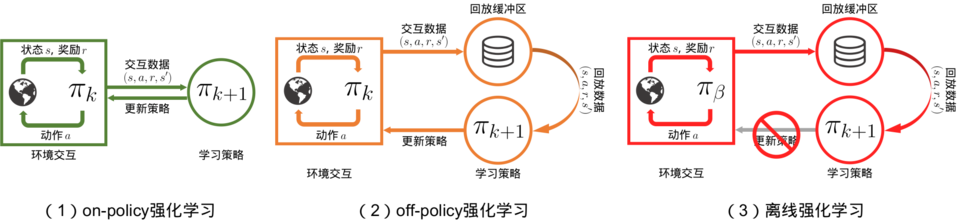

In [3]:
Image(filename='./on-off-policy.png')

# 批量限制 Q-learning 算法

图 18-1 中的离线强化学习和离线策略强化学习很像，都要从经验回放池中采样进行训练，并且离线策略算法的策略评估方式也多种多样。

因此，研究者们最开始尝试将离线策略算法直接照搬到离线的环境下，仅仅是去掉算法中和环境交互的部分。**然而，这种做法完全失败了**。

**研究者进行了 3 个简单的实验:**
- 第一个实验(**完全回放**)，使用 DDPG 算法训练了一个智能体，并将智能体与环境交互的所有数据都记录下来，再用这些数据训练离线 DDPG 智能体。
- 第二个实验(**同步训练**)，在线 DDPG 算法在训练时每次从经验回放池中采样，并用相同的数据同步训练离线 DDPG 智能体，这样两个智能体甚至连训练时用到的数据顺序都完全相同。
- 第三个实验(**模仿训练**)，在线 DDPG 算法在训练完毕后作为专家，在环境中采集大量数据，供离线 DDPG 智能体学习。

这 3 个实验，即完全回放、同步训练、模仿训练的结果依次如图 18-2 所示。

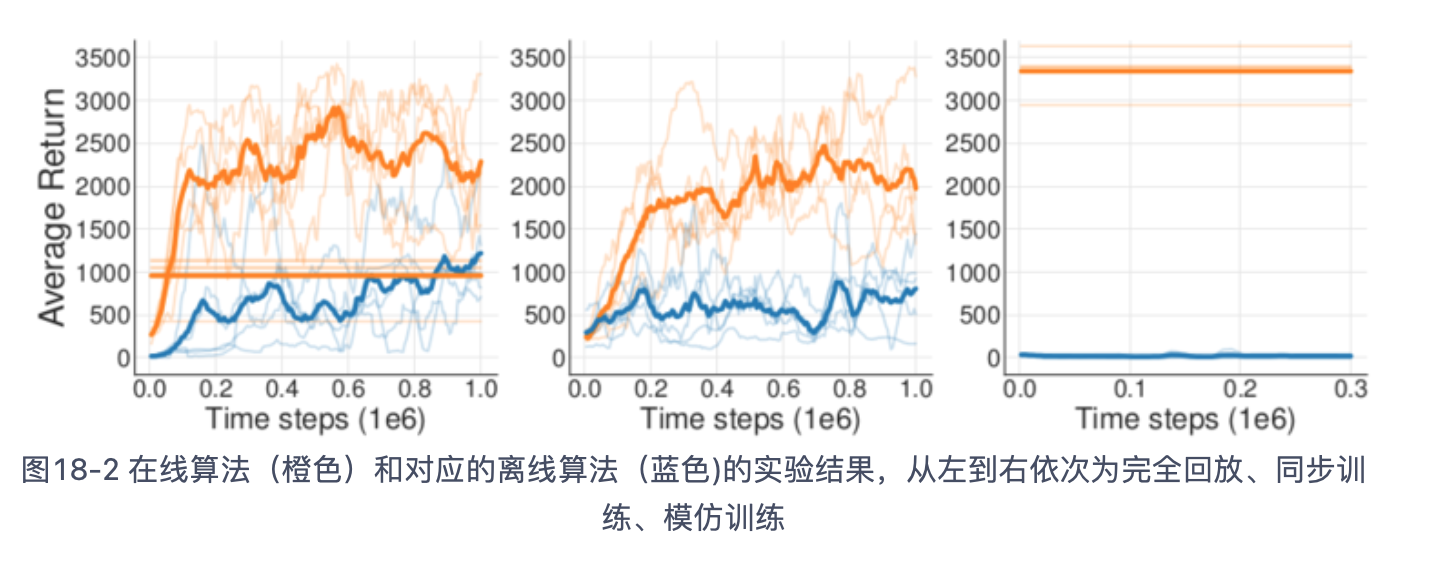

In [4]:
Image(filename='./compare3.png')

让人惊讶的是，**3 个实验中，离线 DDPG 智能体的表现都远远差于在线 DDPG 智能体**，

即便是第二个实验的同步训练都无法提高离线智能体的表现。

在第三个模仿训练实验中，离线智能体面对非常优秀的数据样本却什么都没学到！

针对这种情况，研究者指出，**外推误差（extrapolation error）是离线策略算法不能直接迁移到离线环境中的原因**。

**外推误差**:
- 是指由于当前策略可能访问到的状态动作对(s,a)与从数据集中采样得到的状态动作对的**分布不匹配而产生的误差**。

**为什么在线强化学习算法没有受到外推误差的影响呢？** 
- 因为对于在线强化学习，即使训练是离线策略的，智能体依然有机会通过与环境交互及时采样到新的数据，从而修正这些误差。
- 但是在离线强化学习中，智能体无法和环境交互。

因此，一般来说，**离线强化学习算法要想办法尽可能地限制外推误差的大小，从而得到较好的策略。**

**为了减少外推误差，当前的策略需要做到只访问与数据集中相似的(s,a)数据。**

**满足这一要求的策略称为批量限制策略（batch-constrained policy）**。
- 具体来说，**这样的策略在选择动作时有 3 个目标：**
    - 最小化选择的动作与数据集中数据的**距离**；
    - 采取动作后能到达与离线数据集中状态**相似的状态**；
    - 最大化函数Q。